# Prediction of Robot Current with Deep Learning

In this notebook we will attempt to predict the joint currents of the Universal Robots' CB5 collaborative robot.

As the robot moves, its joints undergo a series of accelerations and decelerations, which positively correlates with the current and temperature of the respective joints.

Using unecessarily high accelerations/decelerations in order to achieve target cycle times is a common practice, although it is not recommended as speeds up the wear and tear of the joints. As the joints near damage, joint currents and temperatures will increase beyond their normal operating range.  

Thus, joint currents and temperatures serve as a barometer for robot health. By predicting current and comparing the predicted and actual values, we can spot deviations which can prompt the operator to carry out inspection to check for any abnormalities in the process.

In [1]:
# import libraries
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime

TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.2.0-rc1'

In [0]:
df = pd.read_csv('robot_data.csv')

In [23]:
df.head()

,datetimes,actual_q_0,actual_q_1,actual_q_2,actual_q_3,actual_q_4,actual_q_5,actual_qd_0,actual_qd_1,actual_qd_2,actual_qd_3,actual_qd_4,actual_qd_5,actual_current_0,actual_current_1,actual_current_2,actual_current_3,actual_current_4,actual_current_5,actual_TCP_force_0,actual_TCP_force_1,actual_TCP_force_2,actual_TCP_force_3,actual_TCP_force_4,actual_TCP_force_5,tcp_force_scalar,joint_temperatures_0,joint_temperatures_1,joint_temperatures_2,joint_temperatures_3,joint_temperatures_4,joint_temperatures_5,robot_mode,safety_mode,actual_robot_voltage,actual_robot_current,actual_joint_voltage_0,actual_joint_voltage_1,actual_joint_voltage_2,actual_joint_voltage_3,actual_joint_voltage_4,actual_joint_voltage_5
0,090320-16:51:32.764,-1.478835,-1.901522,-1.670028,-1.174021,1.563821,-1.506715,0.009926,0.082664,-0.114835,0.026482,-0.000235,0.007337,0.024118,4.963524,0.589481,0.302194,0.003525,0.075245,0.314218,0.340993,0.325423,-0.063105,-0.005376,0.053879,0.566489,31.3125,32.75,31.9375,36.0,38.9375,40.5625,7,1,47.866001,1.138014,47.613598,47.785591,47.771259,47.670929,47.599266,47.599266
1,090320-16:51:32.772,-1.478751,-1.900770,-1.671017,-1.173825,1.563821,-1.506666,0.010561,0.102170,-0.145878,0.034291,-0.000289,0.008375,0.106461,5.121841,0.556772,0.370460,-0.009604,0.113608,0.391996,-0.606577,0.582373,-0.068929,-0.012156,0.063155,0.927769,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.879436,1.144727,47.656597,47.756924,47.756924,47.642265,47.642265,47.656597
2,090320-16:51:32.780,-1.478701,-1.899873,-1.672268,-1.173474,1.563821,-1.506583,0.011201,0.123539,-0.174469,0.042851,-0.001241,0.009539,0.245761,5.115959,0.581294,0.447407,-0.003248,0.145825,-0.185366,-1.303136,0.954734,-0.109836,0.009919,0.091900,1.626051,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.895557,1.167112,47.685261,47.799923,47.785591,47.670929,47.713928,47.656597
3,090320-16:51:32.788,-1.478581,-1.898762,-1.673820,-1.173196,1.563773,-1.506497,0.013046,0.146046,-0.200534,0.049259,-0.000841,0.011273,0.217305,5.052113,0.482123,0.551909,-0.006252,0.147575,-0.141447,-1.304469,0.495625,-0.097770,0.009798,0.111513,1.402601,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.854359,1.149209,47.656597,47.771259,47.756924,47.613598,47.627930,47.627930
4,090320-16:51:32.795,-1.478474,-1.897543,-1.675562,-1.172857,1.563809,-1.506437,0.012909,0.164378,-0.228954,0.056996,-0.000577,0.010899,0.268318,5.301417,0.210789,0.702032,-0.000374,0.178927,-0.029139,0.004449,-0.089967,-0.036488,0.002627,0.136628,0.094673,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.881226,1.276774,47.656597,47.799923,47.713928,47.584930,47.642265,47.627930


In [24]:
df.shape

(3703, 42)

## Data Exploration and Cleaning

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [0]:
# convert str to datetime
df['datetimes'] = df['datetimes'].map(lambda x: datetime.datetime.strptime(x, "%d%m%y-%H:%M:%S.%f"))

In [0]:
# convert datetimes to time elapsed
time_elapsed = []
prev_dt = None

for i, dt in enumerate(df['datetimes']):
  if i == 0:
    time_elapsed.append(0)
    prev_dt = dt
  else:
    interval = float((dt-prev_dt).microseconds)/1e6
    time_elapsed.append(time_elapsed[i-1] + interval)
    prev_dt = dt

In [0]:
# insert new column
df.insert(0, 'time_elapsed', time_elapsed)

In [0]:
# drop the datetime column
df.drop('datetimes', axis=1, inplace=True)

In [30]:
df.head()

,time_elapsed,actual_q_0,actual_q_1,actual_q_2,actual_q_3,actual_q_4,actual_q_5,actual_qd_0,actual_qd_1,actual_qd_2,actual_qd_3,actual_qd_4,actual_qd_5,actual_current_0,actual_current_1,actual_current_2,actual_current_3,actual_current_4,actual_current_5,actual_TCP_force_0,actual_TCP_force_1,actual_TCP_force_2,actual_TCP_force_3,actual_TCP_force_4,actual_TCP_force_5,tcp_force_scalar,joint_temperatures_0,joint_temperatures_1,joint_temperatures_2,joint_temperatures_3,joint_temperatures_4,joint_temperatures_5,robot_mode,safety_mode,actual_robot_voltage,actual_robot_current,actual_joint_voltage_0,actual_joint_voltage_1,actual_joint_voltage_2,actual_joint_voltage_3,actual_joint_voltage_4,actual_joint_voltage_5
0,0.000,-1.478835,-1.901522,-1.670028,-1.174021,1.563821,-1.506715,0.009926,0.082664,-0.114835,0.026482,-0.000235,0.007337,0.024118,4.963524,0.589481,0.302194,0.003525,0.075245,0.314218,0.340993,0.325423,-0.063105,-0.005376,0.053879,0.566489,31.3125,32.75,31.9375,36.0,38.9375,40.5625,7,1,47.866001,1.138014,47.613598,47.785591,47.771259,47.670929,47.599266,47.599266
1,0.008,-1.478751,-1.900770,-1.671017,-1.173825,1.563821,-1.506666,0.010561,0.102170,-0.145878,0.034291,-0.000289,0.008375,0.106461,5.121841,0.556772,0.370460,-0.009604,0.113608,0.391996,-0.606577,0.582373,-0.068929,-0.012156,0.063155,0.927769,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.879436,1.144727,47.656597,47.756924,47.756924,47.642265,47.642265,47.656597
2,0.016,-1.478701,-1.899873,-1.672268,-1.173474,1.563821,-1.506583,0.011201,0.123539,-0.174469,0.042851,-0.001241,0.009539,0.245761,5.115959,0.581294,0.447407,-0.003248,0.145825,-0.185366,-1.303136,0.954734,-0.109836,0.009919,0.091900,1.626051,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.895557,1.167112,47.685261,47.799923,47.785591,47.670929,47.713928,47.656597
3,0.024,-1.478581,-1.898762,-1.673820,-1.173196,1.563773,-1.506497,0.013046,0.146046,-0.200534,0.049259,-0.000841,0.011273,0.217305,5.052113,0.482123,0.551909,-0.006252,0.147575,-0.141447,-1.304469,0.495625,-0.097770,0.009798,0.111513,1.402601,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.854359,1.149209,47.656597,47.771259,47.756924,47.613598,47.627930,47.627930
4,0.031,-1.478474,-1.897543,-1.675562,-1.172857,1.563809,-1.506437,0.012909,0.164378,-0.228954,0.056996,-0.000577,0.010899,0.268318,5.301417,0.210789,0.702032,-0.000374,0.178927,-0.029139,0.004449,-0.089967,-0.036488,0.002627,0.136628,0.094673,31.3125,32.75,31.9375,36.0,38.9375,40.5000,7,1,47.881226,1.276774,47.656597,47.799923,47.713928,47.584930,47.642265,47.627930


In [0]:
df_current = df[['time_elapsed', 'actual_current_0', 'actual_current_1', 'actual_current_2', 'actual_current_3', 'actual_current_4', 'actual_current_5']]


In [0]:
# rename the columns
columns = ['time', 'base_current', 'shoulder_current', 'elbow_current', 'wrist1_current', 'wrist2_current', 'wrist3_current']
df_current.columns = columns

### Line Plots of Joint Currents Vs Time

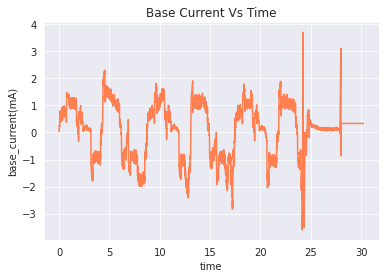

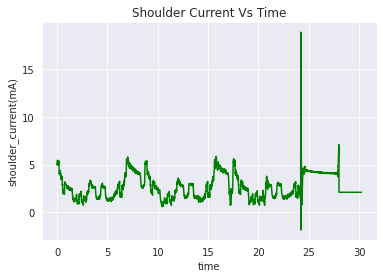

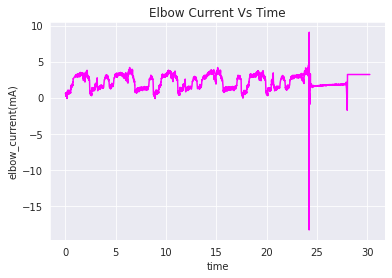

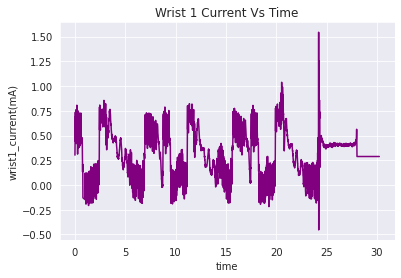

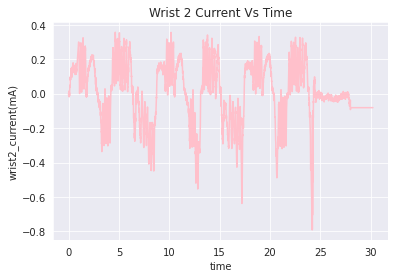

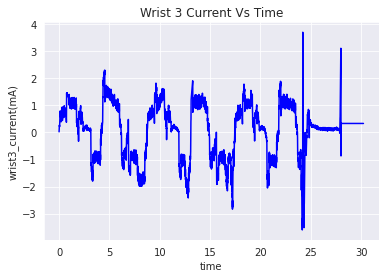

In [33]:
ax = sns.lineplot(x='time', y='base_current', color='coral', data=df_current)
ax.set_title('Base Current Vs Time')
ax.set_ylabel('base_current(mA)')
plt.show()

ax = sns.lineplot(x='time', y='shoulder_current', color='green', data=df_current)
ax.set_title('Shoulder Current Vs Time')
ax.set_ylabel('shoulder_current(mA)')
plt.show()

ax = sns.lineplot(x='time', y='elbow_current', color='magenta', data=df_current)
ax.set_title('Elbow Current Vs Time')
ax.set_ylabel('elbow_current(mA)')
plt.show()

ax = sns.lineplot(x='time', y='wrist1_current', color='purple', data=df_current)
ax.set_title('Wrist 1 Current Vs Time')
ax.set_ylabel('wrist1_current(mA)')
plt.show()

ax = sns.lineplot(x='time', y='wrist2_current', color='pink', data=df_current)
ax.set_title('Wrist 2 Current Vs Time')
ax.set_ylabel('wrist2_current(mA)')
plt.show()


ax = sns.lineplot(x='time', y='base_current', color='blue', data=df_current)
ax.set_title('Wrist 3 Current Vs Time')
ax.set_ylabel('wrist3_current(mA)')
plt.show()

In [0]:
# save the dataset
df_current.to_csv('current_data.csv')

## Model Training

We will split the time series into a training period and a test period. 

Training will be done on the training period, and then test performance on the test period. 

For best performance, we will adjust our **window size** to be as close as possible to the cycle time of the robot operation (~5s = **625** time steps)

An **LSTM deep learning model** will be created, using **CNN, LSTM, and Dense** layers, using the **SGD optimizer** and the **Huber loss function** which is known to be less sensitive to noisy data.



![LSTM Model](lstm_graph.png)

LSTMs preserve the training state throughout the life of the training; the state is passed from cell to cell, timestep to timestep. The state can also be bidirectional - it can move forwards and backwards through the network.

This means that the data from the earlier window can have a greater impact on the overall projection compared to RNNs.

In [0]:
# get numpy arrays
time = np.array(df_current['time'])
base = np.array(df_current['base_current'])
shoulder = np.array(df_current['shoulder_current'])
elbow = np.array(df_current['elbow_current'])
wrist_1 = np.array(df_current['wrist1_current'])
wrist_2 = np.array(df_current['wrist2_current'])
wrist_3 = np.array(df_current['wrist3_current'])

In [0]:
# attempt on base current

# train test split 80/20
train_split_length = int(0.8 * len(df_current))

# split
time_train = time[:train_split_length]
base_train = base[:train_split_length]

time_valid = time[train_split_length:]
base_valid = base[train_split_length:] 

In [37]:
time_train.shape

(2962,)

In [0]:
def windowed_dataset(input_array, window_size, batch_size, shuffle_buffer):
    input_array = tf.expand_dims(input_array, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(input_array)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 625   #~~5/0.008
batch_size = 50
shuffle_buffer_size = 2962   # shuffling helps to prevent sequence bias. Same length as training data

train_set = windowed_dataset(base_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

# build the model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=64,
                                                           kernel_size=5,
                                                           strides=1, 
                                                           padding='causal',
                                                           activation='relu',
                                                           input_shape=[None, 1]
                                                           ),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100)
])

# learning rate optimizer
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    # lambda function here defines the range of lr values to try (from 10^-8 to 10^-4)
    lambda epoch: 1e-8 * 10 **(epoch/20)
)

# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=3)

# SGD optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# compile model with optimizer and huber loss function, using MAE as the metric
# of performance
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
47/47 [==============================] - 6s 126ms/step - loss: 0.7163 - mae: 1.0929 - lr: 1.0000e-08
Epoch 2/100
47/47 [==============================] - 6s 126ms/step - loss: 0.6969 - mae: 1.0736 - lr: 1.1220e-08
Epoch 3/100
47/47 [==============================] - 6s 126ms/step - loss: 0.6747 - mae: 1.0512 - lr: 1.2589e-08
Epoch 4/100
47/47 [==============================] - 6s 126ms/step - loss: 0.6498 - mae: 1.0259 - lr: 1.4125e-08
Epoch 5/100
47/47 [==============================] - 6s 126ms/step - loss: 0.6223 - mae: 0.9974 - lr: 1.5849e-08
Epoch 6/100
47/47 [==============================] - 6s 127ms/step - loss: 0.5913 - mae: 0.9652 - lr: 1.7783e-08
Epoch 7/100
47/47 [==============================] - 6s 126ms/step - loss: 0.5574 - mae: 0.9288 - lr: 1.9953e-08
Epoch 8/100
47/47 [==============================] - 6s 126ms/step - loss: 0.5197 - mae: 0.8883 - lr: 2.2387e-08
Epoch 9/100
47/47 [==============================] - 6s 126ms/step - loss: 0.4788 - mae: 0.8437 

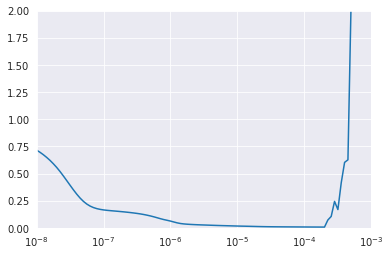

In [61]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 2])
plt.show()

From the graph above, the optimal learning rate is around **1 x 10^-5**.

Learning rates greater than 10^-4 caused divergent behavior; the loss and mean absolute error increased exponentially.

We will **re-train** the model using the learning rate of 1e-5.

In [66]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dataset = windowed_dataset(base_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

# build the model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=64,
                                                           kernel_size=5,
                                                           strides=1, 
                                                           padding='causal',
                                                           activation='relu',
                                                           input_shape=[None, 1]
                                                           ),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100)
])


# SGD optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

# compile model with optimizer and huber loss function, using MAE as the metric
# of performance
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(dataset, epochs=100)

Epoch 1/100
47/47 [==============================] - 6s 130ms/step - loss: 0.1968 - mae: 0.4637
Epoch 2/100
47/47 [==============================] - 6s 125ms/step - loss: 0.0387 - mae: 0.1885
Epoch 3/100
47/47 [==============================] - 6s 126ms/step - loss: 0.0287 - mae: 0.1650
Epoch 4/100
47/47 [==============================] - 6s 127ms/step - loss: 0.0253 - mae: 0.1570
Epoch 5/100
47/47 [==============================] - 6s 127ms/step - loss: 0.0230 - mae: 0.1517
Epoch 6/100
47/47 [==============================] - 6s 126ms/step - loss: 0.0214 - mae: 0.1470
Epoch 7/100
47/47 [==============================] - 6s 127ms/step - loss: 0.0200 - mae: 0.1425
Epoch 8/100
47/47 [==============================] - 6s 125ms/step - loss: 0.0189 - mae: 0.1389
Epoch 9/100
47/47 [==============================] - 6s 126ms/step - loss: 0.0180 - mae: 0.1362
Epoch 10/100
47/47 [==============================] - 6s 126ms/step - loss: 0.0174 - mae: 0.1340
Epoch 11/100
47/47 [===================

## Training Loss Vs Time

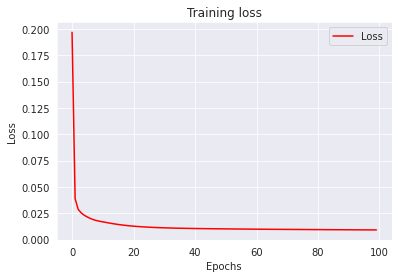

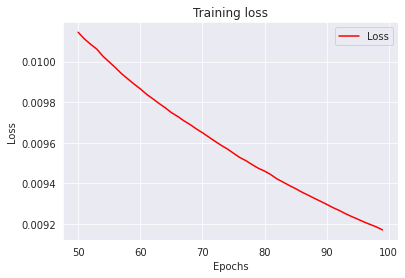

<Figure size 432x288 with 0 Axes>

In [68]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[50:]
zoomed_epochs = range(50,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

plt.show()

## Save the model

In [0]:
# save the model
model.save('robot_lstm.h5')

In [70]:
# load the model
model = tf.keras.models.load_model('robot_lstm.h5')

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 120)         60000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 120)         86880     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3630      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

## Plot the forecast

In [0]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(50).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [0]:
def plot_series(time, series, label, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label)
    plt.xlabel("Time")
    plt.ylabel("Current")
    plt.grid(True)

In [0]:
series = base

In [0]:
# pass in the entire base current data
forecast = model_forecast(model, series, window_size)

In [0]:
forecast = forecast[len(time_train) - window_size:-1, -1, 0]

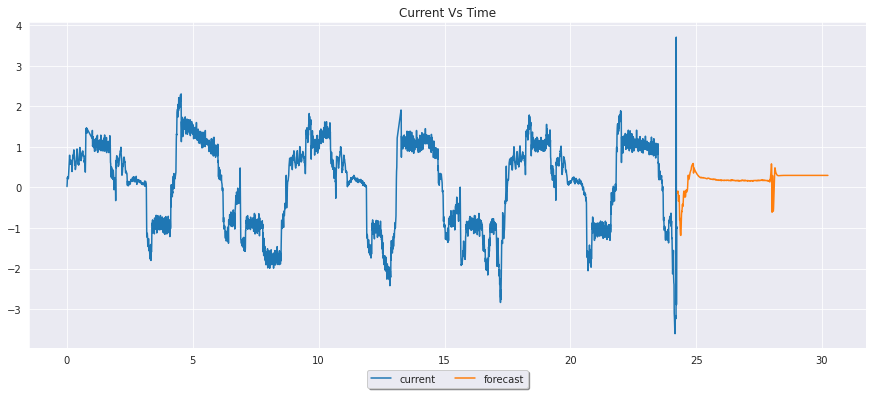

In [80]:
plt.figure(figsize=(15, 6))

time = np.array(df_current['time'])

ax = plt.subplot(111)
ax.plot(time_train, base_train, label='current')
ax.plot(time_valid, forecast, label='forecast')
plt.title('Current Vs Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

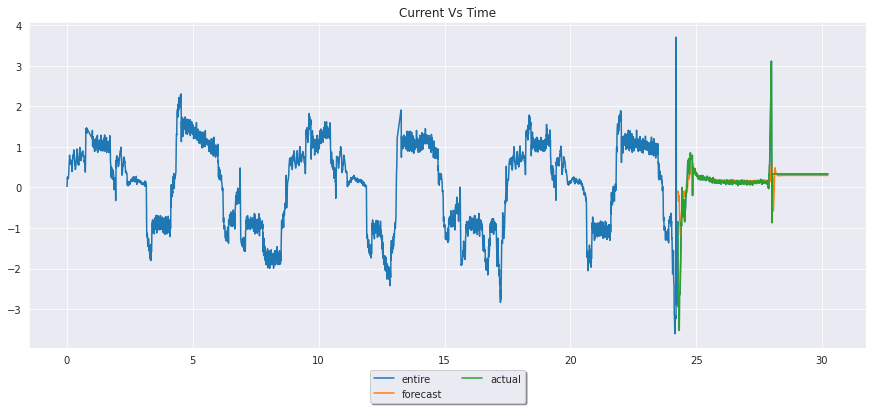

In [81]:
plt.figure(figsize=(15, 6))

ax = plt.subplot(111)
ax.plot(time, base, label='entire')
ax.plot(time_valid, forecast, label='forecast')
ax.plot(time_valid, base_valid,  label='actual')
plt.title('Current Vs Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

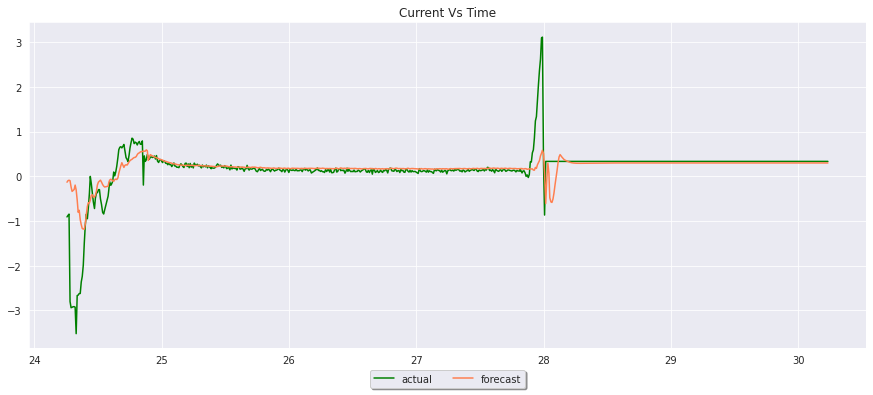

In [82]:
plt.figure(figsize=(15, 6))

ax = plt.subplot(111)
ax.plot(time_valid, base_valid,  label='actual', color='green')
ax.plot(time_valid, forecast, label='forecast', color='coral')
plt.title('Current Vs Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()